# Wstęp

### Cel i zakres badania
Celem niniejszej pracy jest analiza popytu na mięso wieprzowe w Polsce w latach 2010–2022 przy użyciu modeli ekonometrycznych. W szczególności badaniu podlegać będzie:
1. **Estymacja elastyczności dochodowej** – oszacowanie wpływu dochodu na poziom konsumpcji wieprzowiny na osobę.
2. **Porównanie trzech funkcji popytu** – wykładniczej, potęgowej oraz funkcji Tornquista I rzędu.
3. **Ocena dopasowania modeli i interpretacja wyników** – wybór najlepszego modelu oraz wyciągnięcie wniosków dotyczących charakteru dobra i reakcji konsumpcji na zmiany cen i dochodów.

### Metodologia i źródła danych

Analiza bazuje na danych rocznych dla Polski za lata 2010–2022, obejmujących:

- `consumption_per_capita` – roczne spożycie mięsa wieprzowego na osobę [kg/os],
- `income` – przeciętny roczny dochód brutto [tys. PLN],

Źródła danych:
- Główny Urząd Statystyczny (GUS)
    - [Przeciętne roczne wynagrodzenie brutto](https://bdl.stat.gov.pl/bdl/metadane/cechy/2497?back=True)
    - [Ludność w Polsce](https://bdl.stat.gov.pl/bdl/metadane/podgrupy/7?back=True)
- Food and Agriculture Organization of the United Nations (FAO):
    - [Roczne spożycie wieprzowiny](https://www.fao.org/faostat/en/#data/FBS?countries=173&elements=2141&items=2733&years=2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022&output_type=table&file_type=csv&submit=true)

W analizie zastosowano trzy podejścia modelowe:

- **Model wykładniczy**
- **Model potęgowy**
- **Model Tornquista I rzędu**

Modele zostaną oszacowane przy użyciu klasycznej metody najmniejszych kwadratów (KMNK / OLS), a ich dopasowanie ocenione będzie na podstawie współczynnika determinacji \( R^2 \), wartości statystyk istotności parametrów oraz analizy reszt.

### Struktura pracy

Niniejszy projekt został podzielony na trzy główne części:

1. **Wstęp** – prezentacja tematu, celu badania, danych oraz metodologii.
2. **Część obliczeniowa** – estymacja trzech modeli ekonometrycznych oraz ich porównanie.
3. **Wnioski końcowe** – analiza uzyskanych rezultatów i ich interpretacja ekonomiczna.

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.optimize import curve_fit
import warnings
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error, root_mean_squared_error

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'DejaVu Sans'

warnings.filterwarnings('ignore')

In [97]:
def exponential_model(x, a, b):
    return np.exp(a + b / x)

def power_model(x, a, b):
    return a * (x ** b)

def tornquist_model(x, a, b):
    return (a * x) / (x + b)

def evaluate_model(y_true, y_pred, model_name):
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{model_name}: R² = {r2:.4f}, MAPE = {mape:.4f}, MAE = {mae:.4f}")

def evaluate_parameters(popt, pcov, model_name):
    se = np.sqrt(np.diag(pcov))
    t_values = popt / se
    df = len(x) - len(popt)
    p_values = [2 * (1 - stats.t.cdf(np.abs(t), df)) for t in t_values]
    
    print(f"\nStatystyki dla {model_name}:")
    for i, (param, stderr, t, p) in enumerate(zip(popt, se, t_values, p_values)):
        print(f"Parametr {i+1}:")
        print(f"  Wartość     = {param:.4f}")
        print(f"  Std. błąd   = {stderr:.4f}")
        print(f"  t-stat      = {t:.4f}")
        print(f"  p-value     = {p:.4f}")

In [98]:
df = pd.read_csv('source/data.csv', sep=',', encoding='utf-8')

x = df["income"].values
y = df["consumption_per_capita"].values
x_range = np.linspace(x.min(), x.max(), 100)

In [99]:
print("Struktura wczytanego zbioru danych:")
print(df.head())

print("\nInformacje o zbiorze danych:")
print(df.info())

print("\nLiczba braków danych w każdej kolumnie:")
print(df.isnull().sum())

df = df.dropna()

Struktura wczytanego zbioru danych:
   year  consumption_per_capita    income
0  2010               52.712356  41220.00
1  2011               53.193633  43502.52
2  2012               49.230148  44932.56
3  2013               46.083118  46529.16
4  2014               50.417632  48047.88

Informacje o zbiorze danych:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   year                    13 non-null     int64  
 1   consumption_per_capita  13 non-null     float64
 2   income                  13 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 444.0 bytes
None

Liczba braków danych w każdej kolumnie:
year                      0
consumption_per_capita    0
income                    0
dtype: int64


In [100]:
print("\nStatystyki opisowe:")
display(df.drop(columns=['year']).describe())


Statystyki opisowe:


,consumption_per_capita,income
count,13.000000,13.000000
mean,53.113435,55293.812308
std,3.089783,11930.392901
min,46.083118,41220.000000
25%,52.712356,46529.160000
50%,53.573763,51486.240000
75%,54.519467,62179.560000
max,57.665551,80467.440000



Statystyki dla Model wykładniczy:
Parametr 1:
  Wartość     = 4.1498
  Std. błąd   = 0.0719
  t-stat      = 57.7280
  p-value     = 0.0000
Parametr 2:
  Wartość     = -9462.5828
  Std. błąd   = 3803.1204
  t-stat      = -2.4881
  p-value     = 0.0301
Model wykładniczy: R² = 0.3587, MAPE = 0.0375, MAE = 1.9457


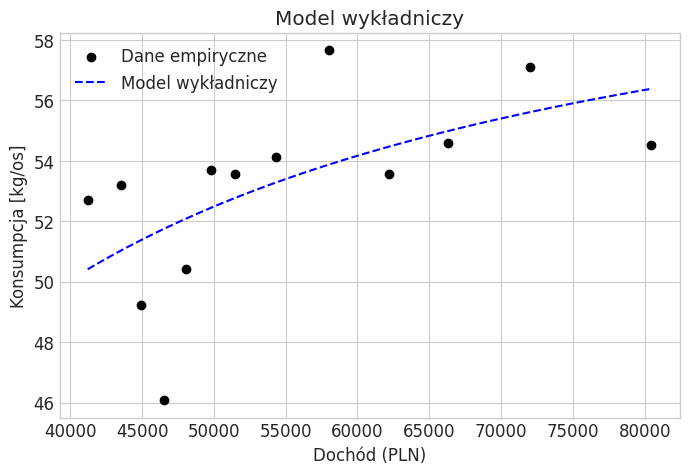

In [101]:
params_exp, pcov_exp = curve_fit(exponential_model, x, y)
y_pred_exp = exponential_model(x, *params_exp)
y_plot_exp = exponential_model(x_range, *params_exp)

evaluate_parameters(params_exp, pcov_exp, "Model wykładniczy")
evaluate_model(y, y_pred_exp, "Model wykładniczy")

plt.figure(figsize=(8, 5))
plt.scatter(x, y, color='black', label='Dane empiryczne')
plt.plot(x_range, y_plot_exp, label='Model wykładniczy', linestyle='--', color='blue')
plt.xlabel("Dochód (PLN)")
plt.ylabel("Konsumpcja [kg/os]")
plt.title("Model wykładniczy")
plt.legend()
plt.grid(True)
plt.show()


Statystyki dla Model potęgowy:
Parametr 1:
  Wartość     = 8.8124
  Std. błąd   = 6.5251
  t-stat      = 1.3505
  p-value     = 0.2040
Parametr 2:
  Wartość     = 0.1647
  Std. błąd   = 0.0678
  t-stat      = 2.4285
  p-value     = 0.0335
Model potęgowy: R² = 0.3472, MAPE = 0.0377, MAE = 1.9564


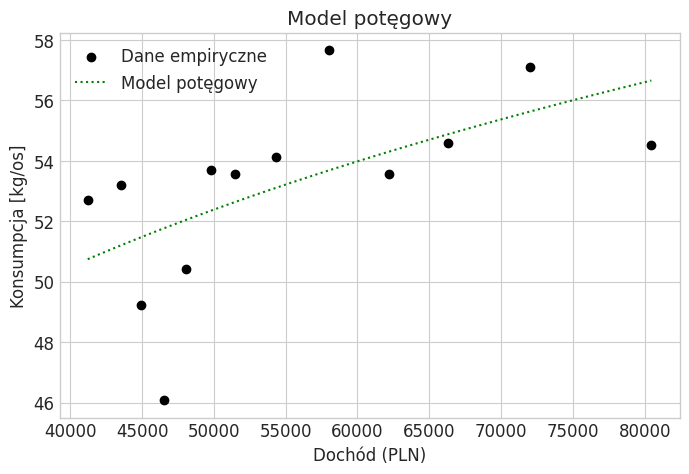

In [102]:
params_power, pcov_power = curve_fit(power_model, x, y)
y_pred_power = power_model(x, *params_power)
y_plot_power = power_model(x_range, *params_power)

evaluate_parameters(params_power, pcov_power, "Model potęgowy")
evaluate_model(y, y_pred_power, "Model potęgowy")

plt.figure(figsize=(8, 5))
plt.scatter(x, y, color='black', label='Dane empiryczne')
plt.plot(x_range, y_plot_power, label='Model potęgowy', linestyle=':', color='green')
plt.xlabel("Dochód (PLN)")
plt.ylabel("Konsumpcja [kg/os]")
plt.title("Model potęgowy")
plt.legend()
plt.grid(True)
plt.show()



Statystyki dla Model Tornquista:
Parametr 1:
  Wartość     = 64.4141
  Std. błąd   = 5.5036
  t-stat      = 11.7040
  p-value     = 0.0000
Parametr 2:
  Wartość     = 11386.6867
  Std. błąd   = 5534.0932
  t-stat      = 2.0576
  p-value     = 0.0641
Model Tornquista: R² = 0.3579, MAPE = 0.0376, MAE = 1.9472


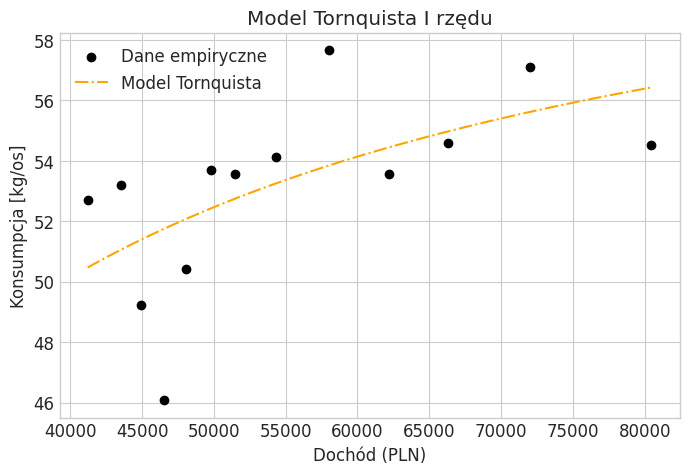

In [103]:
params_torn, pcov_torn = curve_fit(tornquist_model, x, y)
y_pred_torn = tornquist_model(x, *params_torn)
y_plot_torn = tornquist_model(x_range, *params_torn)

evaluate_parameters(params_torn, pcov_torn, "Model Tornquista")
evaluate_model(y, y_pred_torn, "Model Tornquista")

plt.figure(figsize=(8, 5))
plt.scatter(x, y, color='black', label='Dane empiryczne')
plt.plot(x_range, y_plot_torn, label='Model Tornquista', linestyle='-.', color='orange')
plt.xlabel("Dochód (PLN)")
plt.ylabel("Konsumpcja [kg/os]")
plt.title("Model Tornquista I rzędu")
plt.legend()
plt.grid(True)
plt.show()